In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import geopandas as gpd
import pandas as pd
from distmetrics import (compute_transformer_zscore, 
                         load_trained_transformer_model, 
                         compute_mahalonobis_dist_2d, 
                         compute_mahalonobis_dist_1d, compute_log_ratio_decrease_metric, compute_cusum_1d, compute_prob_cusum_1d)
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import warnings
import numpy as np
import concurrent.futures
import rasterio
from pyproj import Transformer
from rasterio.crs import CRS
from tqdm import tqdm
from pathlib import Path
from val_io import get_burst_time_series_around_point, get_utm_coords
from distmetrics import despeckle_rtc_arrs_with_tv
import json
from rasterio.transform import rowcol

# Parameters

In [4]:
SITE_ID = 158 # 40 #95
IDX_BURST = 1 # should be 0 or 1. Note that some sites only have 1 burst, so only 0 IDX is valid
LOOKBACK_DELTA_DAYS = 365 

MAX_PRE_IMGS = 10
MIN_PRE_IMGS = 4

N_WORKERS_IO = 10

WINDOW_SIZE = 101

DISTMETRIC_NAME = 'transformer'

# Site Table

In [5]:
df_sites = gpd.read_file('data/val_sites_subset.geojson')
df_sites.head()

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,jpl_burst_id,geometry
0,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,T036-076228-IW3,POINT (19.33289 4.57490)
1,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,T108-230715-IW2,POINT (48.77698 31.75490)
2,13,VLmaj,Crop cycle change,2021-10-03,NaT,39STR,T101-214979-IW1,POINT (48.77698 31.75490)
3,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,T014-028130-IW2,POINT (36.61178 35.52891)
4,22,VLmin,Natural browning,2021-12-19,2021-12-12,37SBV,T021-043823-IW2,POINT (36.61178 35.52891)


In [6]:
df_site = df_sites[df_sites.site_id == SITE_ID].reset_index(drop=True)
df_site

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,jpl_burst_id,geometry
0,158,VLmaj,Crop cycle change,2021-11-13,2021-11-03,37TCN,T167-357347-IW1,POINT (37.02294 47.62284)
1,158,VLmaj,Crop cycle change,2021-11-13,2021-11-03,37TCN,T116-247291-IW3,POINT (37.02294 47.62284)
2,158,VLmaj,Crop cycle change,2021-11-13,2021-11-03,37TCN,T167-357346-IW1,POINT (37.02294 47.62284)


# Full Validation Time Series

In [7]:
df_val_ts = pd.read_csv(f'data/val_timeseries_by_site/site_{SITE_ID}.csv')
df_val_ts['date'] = pd.to_datetime(df_val_ts['date'])
df_val_ts.head()

,site_id,date,obs
0,158,2021-10-01,noObs
1,158,2021-10-02,noObs
2,158,2021-10-03,noObs
3,158,2021-10-04,noObs
4,158,2021-10-05,noChange


# Bursts

In [8]:
df_val_bursts = gpd.read_parquet('data/validation_bursts_v1_coverage_updated.parquet')
df_val_bursts.head()

,jpl_burst_id,geometry,n_acquisitions,site_id
0,T005-008692-IW2,"POLYGON ((-97.21446 17.86505, -97.21446 17.864...",104,72
1,T008-015865-IW2,"POLYGON ((-1.50129 41.44183, -1.50130 41.44156...",101,150
2,T012-024584-IW1,"POLYGON ((-103.78409 20.20832, -103.78409 20.2...",101,34
3,T014-028130-IW2,"POLYGON ((37.01648 35.59545, 37.01649 35.59518...",100,22
4,T014-028131-IW2,"POLYGON ((36.98085 35.76145, 36.98085 35.76118...",38,22


In [9]:
df_bursts_for_site = df_val_bursts[df_val_bursts.site_id == SITE_ID].reset_index(drop=True)
df_bursts_for_site.head()

,jpl_burst_id,geometry,n_acquisitions,site_id
0,T116-247291-IW3,"POLYGON ((37.37307 47.74900, 37.37304 47.74873...",102,158
1,T167-357346-IW1,"POLYGON ((36.18999 47.90358, 36.18995 47.90277...",102,158
2,T167-357347-IW1,"POLYGON ((36.14347 47.73856, 36.14334 47.73641...",102,158


# RTC Data

In [10]:
BURST_ID = df_bursts_for_site.iloc[IDX_BURST].jpl_burst_id

In [11]:
out = Path('out')
site_burst_dir = out / f'site_{SITE_ID}' / BURST_ID
site_burst_dir.mkdir(exist_ok=True, parents=True)

In [12]:
rtc_dir = site_burst_dir / 'rtc_ts'
rtc_dir, rtc_dir.exists()

(PosixPath('out/site_158/T167-357346-IW1/rtc_ts'), True)

In [13]:
vv_paths = list(rtc_dir.glob('*_VV.tif'))
vh_paths = list(rtc_dir.glob('*_VH.tif'))

pre_post_idx = json.load(open(rtc_dir / f'idx_delta{LOOKBACK_DELTA_DAYS}.json'))
pre_post_dts = json.load(open(rtc_dir / f'dates_delta{LOOKBACK_DELTA_DAYS}.json'))

# Load Data

In [14]:
def open_one_arr(path: Path) -> np.ndarray:
    with rasterio.open(path) as ds:
        X = ds.read(1)
    return X
arrs_vv_d = list(map(open_one_arr, tqdm(vv_paths)))
arrs_vh_d = list(map(open_one_arr, tqdm(vh_paths)))

with rasterio.open(vv_paths[0]) as ds:
    prof_ref = ds.profile

100%|███████████████████████████████████████| 102/102 [00:00<00:00, 330.78it/s]


# Get Val site and indices

In [15]:
geo = df_site.geometry[0]
lon, lat = geo.x, geo.y

In [16]:
utm_x, utm_y = get_utm_coords(prof_ref['crs'], lon, lat)
utm_x, utm_y

(802251.1509761794, 5282226.241872362)

In [17]:
idx_y, idx_x = rowcol(prof_ref['transform'], utm_x, utm_y)
idx_y, idx_x

(50, 50)

# Calculate Metrics

In [18]:
def compute_distmetric(pre_vv=None,
               pre_vh=None,
               post_vv=None,
               post_vh=None):
    """Pass in all data; use only what is necesary"""
    if DISTMETRIC_NAME == 'transformer':
        if any([len(pre) < 2 for pre in pre_vv + pre_vh]):
            raise ValueError('pre images must be at least 2')
        model = load_trained_transformer_model()
        dist_ob = compute_transformer_zscore(model,
                                             pre_vv,
                                             pre_vh,
                                             post_vv,
                                             post_vh,
                                             stride=2,
                                             batch_size=128,
                                            tqdm_enabled=False)
        distance = dist_ob.dist
    elif DISTMETRIC_NAME == 'mahalanobis_2d':
        dist_ob = compute_mahalonobis_dist_2d(pre_vv,
                                          pre_vh,
                                          post_vv,
                                          post_vh,
                                          eig_lb=.01,
                                          window_size=3,
                                          logit_transformed=True)
        distance = dist_ob.dist
    elif DISTMETRIC_NAME == 'mahalanobis_vh':
        dist_ob = compute_mahalonobis_dist_1d(
                                          pre_vh,
                                          post_vh,
                                          sigma_lb=.01,
                                          window_size=3,
                                          logit_transformed=True)
        distance = dist_ob.dist
    elif DISTMETRIC_NAME == 'log_ratio_vh':
        dist_ob = compute_log_ratio_decrease_metric(pre_vh,
                                          post_vh,
                                          window_size=1,
                                          qual_stat_for_pre_imgs='median')
        distance = dist_ob.dist

    elif DISTMETRIC_NAME == 'mahalanobis_1d_max':
        dist_ob_vh = compute_mahalonobis_dist_1d(
                                          pre_vh,
                                          post_vh,
                                          sigma_lb=.01,
                                          window_size=3,
                                          logit_transformed=True)
        distance_vh = dist_ob_vh.dist

        dist_ob_vv = compute_mahalonobis_dist_1d(
                                          pre_vv,
                                          post_vv,
                                          sigma_lb=.01,
                                          window_size=3,
                                          logit_transformed=True)
        distance_vv = dist_ob_vv.dist
        distance = np.maximum(distance_vv, distance_vh)

    elif DISTMETRIC_NAME == 'cusum_prob_max':
        dist_ob_vh = compute_prob_cusum_1d(
                                          pre_vh,
                                          post_vh)
        distance_vh = dist_ob_vh.dist

        dist_ob_vv = compute_prob_cusum_1d(
                                          pre_vv,
                                          post_vv)
        distance_vv = dist_ob_vv.dist
        distance = np.maximum(distance_vv, distance_vh)
    elif DISTMETRIC_NAME == 'cusum_vh':
        dist_ob = compute_cusum_1d(pre_vh,
                                   post_vh)

        distance = dist_ob.dist
    
    else:
        raise NotImplementedError
    return distance

In [19]:
metrics = [compute_distmetric([arrs_vv_d[k] for k in idxs['pre']],
                              [arrs_vh_d[k] for k in idxs['pre']],
                              arrs_vv_d[idxs['post'][0]],
                              arrs_vh_d[idxs['post'][0]])
          for idxs in tqdm(pre_post_idx)]

100%|██████████████████████████████████████████| 38/38 [00:35<00:00,  1.08it/s]


In [20]:
metrics_at_site = [m[idx_y , idx_x] for m in metrics]
mean_metrics_at_site = [np.nanmean(m[max(0, idx_y-1):idx_y+1 ,max(idx_x-1, 0):idx_x+1]) for m in metrics]

post_dates = [pd.Timestamp(d['post'][0]) for d in pre_post_dts]

In [21]:
n = len(post_dates)
assert(n == len(metrics_at_site))
df_ts = pd.DataFrame({'site_id': [SITE_ID] * n,
                      'burst_id': [BURST_ID] * n,
                      'acq_date_post': post_dates,
                      'metric': metrics_at_site,
                      'metric_90m': mean_metrics_at_site})
# Ensures that there are no additional dates beyond val time period
ind = (df_ts.acq_date_post < pd.Timestamp('2022-10-01')) & (df_ts.acq_date_post >= pd.Timestamp('2021-10-01'))
df_ts = df_ts[ind].reset_index(drop=True)
df_ts.head(10)

,site_id,burst_id,acq_date_post,metric,metric_90m
0,158,T167-357346-IW1,2021-10-22 03:47:25,0.722342,0.656064
1,158,T167-357346-IW1,2021-10-28 03:47:57,0.599486,0.614164
2,158,T167-357346-IW1,2021-11-03 03:47:24,0.481720,0.476165
3,158,T167-357346-IW1,2021-11-09 03:47:57,1.657224,1.632876
4,158,T167-357346-IW1,2021-11-15 03:47:24,1.011365,0.962091
5,158,T167-357346-IW1,2021-11-21 03:47:57,0.564074,0.596361
6,158,T167-357346-IW1,2021-11-27 03:47:24,0.909735,0.818047
7,158,T167-357346-IW1,2021-12-03 03:47:56,4.699274,4.641603
8,158,T167-357346-IW1,2021-12-09 03:47:23,2.353741,2.362461
9,158,T167-357346-IW1,2021-12-15 03:47:56,2.156008,2.075150


In [22]:
df_val_ts.head()

,site_id,date,obs
0,158,2021-10-01,noObs
1,158,2021-10-02,noObs
2,158,2021-10-03,noObs
3,158,2021-10-04,noObs
4,158,2021-10-05,noChange


In [23]:
def get_val_obs(acq: pd.Timestamp):
    ind = df_val_ts.date == str(acq.date())
    assert (ind.sum() == 1)
    obs = df_val_ts[ind].obs.tolist()[0]
    return obs

In [24]:
df_ts['val_obs'] = df_ts.acq_date_post.map(get_val_obs)
df_ts.head()

,site_id,burst_id,acq_date_post,metric,metric_90m,val_obs
0,158,T167-357346-IW1,2021-10-22 03:47:25,0.722342,0.656064,noChange
1,158,T167-357346-IW1,2021-10-28 03:47:57,0.599486,0.614164,noChange
2,158,T167-357346-IW1,2021-11-03 03:47:24,0.481720,0.476165,noChange
3,158,T167-357346-IW1,2021-11-09 03:47:57,1.657224,1.632876,noObs
4,158,T167-357346-IW1,2021-11-15 03:47:24,1.011365,0.962091,OCmaj


In [26]:
df_ts.val_obs

0     noChange
1     noChange
2     noChange
3        noObs
4        OCmaj
5        OCmaj
6        OCmaj
7        OCmaj
8        OCmaj
9        OCmaj
10       OCmaj
11       OCmaj
12       OCmaj
13       OCmaj
14       OCmaj
15       OCmaj
16       OCmaj
17       OCmaj
18       OCmaj
19       OCmaj
20     OCtotal
21    noChange
22    noChange
23    noChange
24       noObs
25    noChange
26       noObs
27    noChange
28    noChange
29       noObs
30       VLmaj
31       noObs
32       noObs
Name: val_obs, dtype: object

In [27]:
def mark_val_change(obs:str, conservative=True):
    change_vals = ['VLmaj', 'OCmaj', 'OCtotal']
    no_change_vals = ['noChange']
    if not conservative:
        change_vals += ['VLmin', 'OCmin']
    else:
        no_change_vals += ['VLmin', 'OCmin']
    
    if obs in change_vals:
        return 1
    elif obs in no_change_vals:
        return 0
    elif obs == 'noObs':
        return 255
    else:
        print(obs)
        raise ValueError

df_ts['val_change_conservative'] = df_ts.val_obs.map(mark_val_change)
df_ts['val_change_aggressive'] = df_ts.val_obs.map(lambda obs: mark_val_change(obs, conservative=False))

df_ts.head()

,site_id,burst_id,acq_date_post,metric,metric_90m,val_obs,val_change_conservative,val_change_aggressive
0,158,T167-357346-IW1,2021-10-22 03:47:25,0.722342,0.656064,noChange,0,0
1,158,T167-357346-IW1,2021-10-28 03:47:57,0.599486,0.614164,noChange,0,0
2,158,T167-357346-IW1,2021-11-03 03:47:24,0.481720,0.476165,noChange,0,0
3,158,T167-357346-IW1,2021-11-09 03:47:57,1.657224,1.632876,noObs,255,255
4,158,T167-357346-IW1,2021-11-15 03:47:24,1.011365,0.962091,OCmaj,1,1


Text(0.5, 0, 'dt')

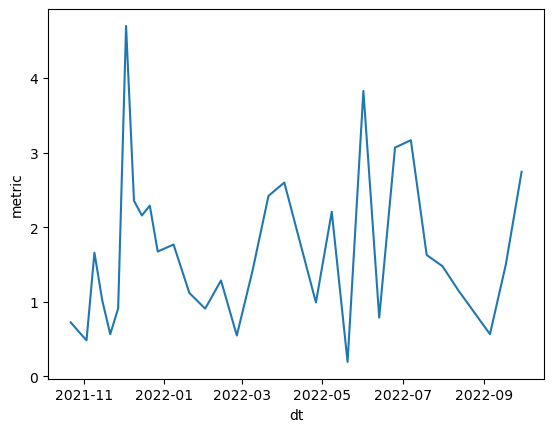

In [28]:
plt.plot(df_ts.acq_date_post, df_ts.metric)
plt.ylabel('metric')
plt.xlabel('dt')

# Changes

In [29]:
def get_threshold():
    """Pass in all data; use only what is necesary"""
    if DISTMETRIC_NAME == 'transformer':
        T_aggressive = 2.5
        T_conservative = 4.5
    elif DISTMETRIC_NAME == 'mahalanobis_2d':
        T_aggressive = 2.5
        T_conservative = 4.5
    elif DISTMETRIC_NAME == 'mahalanobis_vh':
        T_aggressive = 2.5
        T_conservative = 4.5
    elif DISTMETRIC_NAME == 'log_ratio_vh':
        T_aggressive = 1
        T_conservative = 2

    elif DISTMETRIC_NAME == 'mahalanobis_1d_max':
        T_aggressive = 2.5
        T_conservative = 4.5

    elif DISTMETRIC_NAME == 'cusum_prob_max':
        T_aggressive = .9
        T_conservative = .95
    elif DISTMETRIC_NAME == 'cusum_vh':
        T_aggressive = .02
        T_conservative = .04
    else:
        raise NotImplementedError
    return T_aggressive, T_conservative

In [30]:
T_aggressive, T_conservative = get_threshold()
T_aggressive, T_conservative

(2.5, 4.5)

In [31]:
changes_aggressive = [int(met > T_aggressive) if ~np.isnan(met) else 255 for met in df_ts.metric.tolist()]
changes_conservative = [int(met > T_conservative) if ~np.isnan(met) else 255 for met in df_ts.metric.tolist()]

In [32]:
df_ts['rtc_changes_aggressive'] = changes_aggressive
df_ts['rtc_changes_conservative'] = changes_conservative
df_ts.head()

,site_id,burst_id,acq_date_post,metric,metric_90m,val_obs,val_change_conservative,val_change_aggressive,rtc_changes_aggressive,rtc_changes_conservative
0,158,T167-357346-IW1,2021-10-22 03:47:25,0.722342,0.656064,noChange,0,0,0,0
1,158,T167-357346-IW1,2021-10-28 03:47:57,0.599486,0.614164,noChange,0,0,0,0
2,158,T167-357346-IW1,2021-11-03 03:47:24,0.481720,0.476165,noChange,0,0,0,0
3,158,T167-357346-IW1,2021-11-09 03:47:57,1.657224,1.632876,noObs,255,255,0,0
4,158,T167-357346-IW1,2021-11-15 03:47:24,1.011365,0.962091,OCmaj,1,1,0,0


# Confirmed

In [33]:
def confirm_changes(arr, min_length=3):
    result = []
    current_run = []
    num_255 = 0

    for num in arr:
        if num == 1:
            current_run.append(1)
        elif num == 255:
            if len(current_run) > 0 and num_255 < 2:
                current_run.append(255)  # Allow up to 2 '255's between '1's
                num_255 += 1
            else:
                # Too many '255's or no valid run of 1's to append to
                if len([x for x in current_run if x == 1]) >= min_length:
                    result.extend(current_run)
                else:
                    result.extend([0] * len(current_run))  # Replace short run with 0's
                current_run = []
                result.append(255)  # Keep the '255' in the result
                num_255 = 0
        else:  # num == 0
            # A '0' means we finalize the current run
            if len([x for x in current_run if x == 1]) >= min_length:
                result.extend(current_run)
            else:
                result.extend([0] * len(current_run))  # Replace short run with 0's
            result.append(0)  # Keep the '0' in the result
            current_run = []
            num_255 = 0

    # Handle the last run of 1's and 255's after the loop
    if len([x for x in current_run if x == 1]) >= min_length or (len(current_run) > 0 and num_255 <= 2):
        result.extend(current_run)
    else:
        result.extend([0] * len(current_run))

    return result

# Example usage
arr = [1, 255, 1, 1, 0, 1, 1, 255, 255, 1, 1, 1, 1, 255, 0, 0, 1, 1, 255, 255, 255, 1, 0, 0, 1, 1, 255, 1]
result = confirm_changes(arr, min_length=3)
print(result)

[1, 255, 1, 1, 0, 1, 1, 255, 255, 1, 1, 1, 1, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 1, 1, 255, 1]


In [34]:
df_ts_final = df_ts.copy()
for c in df_ts.columns:
    if 'change' in c:
        print(c)
        df_ts_final[c + '_confirmed'] = confirm_changes(df_ts[c].tolist())

val_change_conservative
val_change_aggressive
rtc_changes_aggressive
rtc_changes_conservative


In [35]:
df_ts.head()

,site_id,burst_id,acq_date_post,metric,metric_90m,val_obs,val_change_conservative,val_change_aggressive,rtc_changes_aggressive,rtc_changes_conservative
0,158,T167-357346-IW1,2021-10-22 03:47:25,0.722342,0.656064,noChange,0,0,0,0
1,158,T167-357346-IW1,2021-10-28 03:47:57,0.599486,0.614164,noChange,0,0,0,0
2,158,T167-357346-IW1,2021-11-03 03:47:24,0.481720,0.476165,noChange,0,0,0,0
3,158,T167-357346-IW1,2021-11-09 03:47:57,1.657224,1.632876,noObs,255,255,0,0
4,158,T167-357346-IW1,2021-11-15 03:47:24,1.011365,0.962091,OCmaj,1,1,0,0


# Reorder Columns

In [36]:
change_columns = [c for c in df_ts_final.columns if 'change' in c]
non_change_columns = [c for c in df_ts_final.columns if 'change' not in c]

df_ts_final = df_ts_final[non_change_columns + sorted(change_columns)]
df_ts_final.head()

,site_id,burst_id,acq_date_post,metric,metric_90m,val_obs,rtc_changes_aggressive,rtc_changes_aggressive_confirmed,rtc_changes_conservative,rtc_changes_conservative_confirmed,val_change_aggressive,val_change_aggressive_confirmed,val_change_conservative,val_change_conservative_confirmed
0,158,T167-357346-IW1,2021-10-22 03:47:25,0.722342,0.656064,noChange,0,0,0,0,0,0,0,0
1,158,T167-357346-IW1,2021-10-28 03:47:57,0.599486,0.614164,noChange,0,0,0,0,0,0,0,0
2,158,T167-357346-IW1,2021-11-03 03:47:24,0.481720,0.476165,noChange,0,0,0,0,0,0,0,0
3,158,T167-357346-IW1,2021-11-09 03:47:57,1.657224,1.632876,noObs,0,0,0,0,255,255,255,255
4,158,T167-357346-IW1,2021-11-15 03:47:24,1.011365,0.962091,OCmaj,0,0,0,0,1,1,1,1


# Serialize

In [37]:
metric_dir = site_burst_dir / 'metrics_ts' 
metric_dir.mkdir(exist_ok=True, parents=True)
metric_dir

PosixPath('out/site_158/T167-357346-IW1/metrics_ts')

In [38]:
df_ts_final.to_parquet(metric_dir / f'{DISTMETRIC_NAME}.parquet')